PPP (with BM4D) Volume Deconvolution
====================================

This example demonstrates the solution of a 3D image deconvolution problem
(involving recovering a 3D volume that has been convolved with a 3D kernel
and corrupted by noise) using the ADMM Plug-and-Play Priors (PPP)
algorithm <cite data-cite="venkatakrishnan-2013-plugandplay2"/>, with the BM4D
<cite data-cite="maggioni-2012-nonlocal"/> denoiser.

In [1]:
import numpy as np

import jax

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot, random
from scico.examples import create_3D_foam_phantom, downsample_volume, tile_volume_slices
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
np.random.seed(1234)
N = 128  # phantom size
Nx, Ny, Nz = N, N, N // 4
upsamp = 2
x_gt_hires = create_3D_foam_phantom((upsamp * Nz, upsamp * Ny, upsamp * Nx), N_sphere=100)
x_gt = downsample_volume(x_gt_hires, upsamp)
x_gt = jax.device_put(x_gt)  # convert to jax array, push to GPU

Set up forward operator and test signal consisting of blurred signal with
additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n, n)) / (n**3)
A = linop.Convolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = random.randn(Ax.shape)
y = Ax + σ * noise

Set up ADMM solver.

In [4]:
f = loss.SquaredL2Loss(y=y, A=A)
C = linop.Identity(x_gt.shape)

λ = 40.0 / 255  # BM4D regularization strength
g = λ * functional.BM4D()

ρ = 1.0  # ADMM penalty parameter
maxiter = 10  # number of ADMM iterations

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=A.T @ y,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 100}),
    itstat_options={"display": True},
)

Run the solver.

In [5]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
x = snp.clip(x, 0, 1)
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  3.16e+01  7.594e+00  2.584e+01      3  3.616e-04


   1  6.01e+01  3.864e+00  1.773e+01      3  3.775e-04


   2  8.68e+01  2.389e+00  1.264e+01      3  2.436e-04


   3  1.10e+02  1.826e+00  9.431e+00      2  9.220e-04


   4  1.34e+02  1.634e+00  7.319e+00      2  6.801e-04


   5  1.59e+02  1.596e+00  5.925e+00      2  5.132e-04


   6  1.81e+02  1.507e+00  4.923e+00      2  3.967e-04


   7  2.01e+02  1.442e+00  4.189e+00      2  3.075e-04


   8  2.20e+02  1.330e+00  3.614e+00      2  2.544e-04


   9  2.39e+02  1.303e+00  3.201e+00      2  2.171e-04


Show slices of the recovered 3D volume.

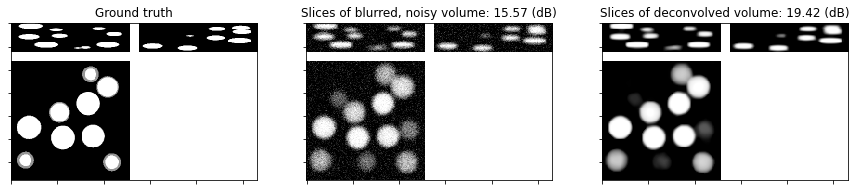

In [6]:
show_id = Nz // 2
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(tile_volume_slices(x_gt), title="Ground truth", fig=fig, ax=ax[0])
nc = n // 2
yc = y[nc:-nc, nc:-nc, nc:-nc]
yc = snp.clip(yc, 0, 1)
plot.imview(
    tile_volume_slices(yc),
    title="Slices of blurred, noisy volume: %.2f (dB)" % metric.psnr(x_gt, yc),
    fig=fig,
    ax=ax[1],
)
plot.imview(
    tile_volume_slices(x),
    title="Slices of deconvolved volume: %.2f (dB)" % metric.psnr(x_gt, x),
    fig=fig,
    ax=ax[2],
)
fig.show()

Plot convergence statistics.

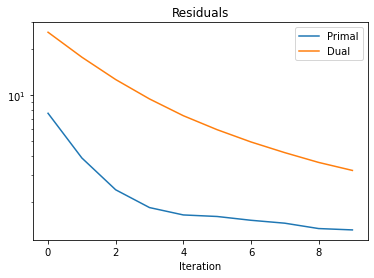

In [7]:
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)